In [58]:
import sys
sys.path.append('../')

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce as reduce
from mpl_toolkits.mplot3d import axes3d

from raypy.utils.vector3 import vec3
from raypy.utils.constants import *
from raypy.geometry.primitive import Primitive
from raypy.geometry.collider import Collider

# Ray Tracer

## Einleitung

Auf Deutsch bezeichnet der englische Begriff „Ray tracing“ das „Nachverfolgen von Strahlen“. Genauer gesagt: Lichtstrahlen. Als Grafik-Technologie ermöglicht Ray tracing die Simulierung von Lichteffekten. Ein Algorithmus sendet hierzu Strahlen in einer 3D-Grafik aus, verfolgt die Strahlenpfade und berechnet ein realistisches Beleuchtungsmodell.

In der realen Welt senden Lichtquellen Lichtstrahlen aus, die dann auf Objekte treffen, dort gebrochen, reflektiert oder gestreut werden und schlussendlich bei der Kamera ankommen.
Die von der Kamera erfassten Lichtstrahlen sind deshalb nur ein Bruchteil der Lichtstrahlen, die von der Lichtquelle zwar ausgesendet, von der Kamera aber nicht aufgenommen werden.

Um nur die, für die Kamera wichtigen, Lichtstrahlen zu berechnen, wird der Weg des Lichts beim Ray tracing entgegen der natürlichen Richtung berechnet.
Die Lichtstrahlen werden also von der Kamera ausgesendet und zurückverfolgt. Die folgende Grafik zeigt wie ein Ray aus der Kamera durch die Bildebene in den drei dimensionalen Raum gesendet wird.

<img src="assets/rayTracingOverview.png" width=500></img>

Beim Ray tracing werden ausgehend vom Augpunkt für jeden Pixel der Bildebene wird ein Ray ausgesendet. Die Rays durchstoßen die Bildebene und treffen dann auf die Objekte im drei dimensionalen Raum.
Die Farbe eines jeden Pixels der Bildebene wird durch die sog. Rendergleichung berechnet.


Eine vereinfachte Beschreibung wäre folgende:

Wenn der Strahl ein Objekt in der Szene schneidet, wird die Farbe des Pixels 
die der Strahl durchläuft, mit der Farbe des Objekts an diesem 
Schnittpunkts gesetzt.

<img src="assets/campixel.gif" alt="this slowpoke moves"  width="500" />

## Was ist ein Ray

Ein Ray, oder auch ein Lichtstrahl, ist die Kombination aus einem Ursprung und einer Richtung.
Ursprung und Richtung eines Rays können jeweils durch einen Vektor angegeben werden. Durch die Linearkombination 
des Ortsvektors (Ursprung) und des Richtungsvektors kann so jeder beliebige Punkt auf einem Ray angegeben werden.

<img src="assets/ray.png" width=300></img>

Die Gleichung für eine Ray ist also folgenden: $P(t)=\vec{O}+\vec{R}*t$

Die einfachste Implementierung eins Rays wäre also folgende:

In [59]:
class Ray:
  """Info of the ray and the media it's travelling"""

  def __init__(self, origin, dir):
      self.origin = origin  # the point where the ray comes from
      self.dir = dir  # direction of the ray

## Die Kamera

Die Kamera befindet sich am Augpunkt und schaut in eine definierte Richtung. Die Anzahl der ausgesendeten Rays hängt von der Anzahl der Pixel ab. 

Die Besonderheit dieser Kamera ist, dass mittels *numpy* alle Rays parallel berechnet werden. Diese Rays können dann wiederum mit *numpy* parallel getrayed werden. So kann das Bild hoch parallel berechnet werden und die Rechendauer verringert sich um ein Vielfaches.

In [60]:
class Camera():
    def __init__(self, look_from, look_at, screen_width=400, screen_height=400, field_of_view=90.):
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.aspect_ratio = float(screen_width) / screen_height
        self.look_from = look_from
        self.look_at = look_at
        self.camera_width = np.tan(field_of_view * np.pi / 180 / 2.) * 2.
        self.camera_height = self.camera_width / self.aspect_ratio

        # camera reference basis in world coordinates
        self.cameraFwd = (look_at - look_from).normalize()
        self.cameraRight = (self.cameraFwd.cross(vec3(0., 1., 0.))).normalize()
        self.cameraUp = self.cameraRight.cross(self.cameraFwd)

        # Pixels coordinates in camera basis:
        self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
        self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)

        # x holds all x values
        # y holds all y values
        # meshgrid creates a rectangular grid with all combinations of (x,y)
        # xx and yy hold the x and y values of the rectangular grid: https://stackoverflow.com/a/42404323
        xx, yy = np.meshgrid(self.x, self.y)
        self.x = xx.flatten()
        self.y = yy.flatten()

    def get_ray(self):

        # in each pixel, take a random position to avoid aliasing.
        x = self.x + (np.random.rand(len(self.x)) - 0.5) * self.camera_width / self.screen_width
        y = self.y + (np.random.rand(len(self.y)) - 0.5) * self.camera_height / self.screen_height

        # set ray direction in world space:
        # ray_origin = self.look_from + self.cameraUp + self.cameraRight
        ray_origin = self.look_from
        ray_dir = (self.look_from + self.cameraUp * y + self.cameraRight * x + self.cameraFwd - ray_origin).normalize()
        return Ray(origin=ray_origin, dir=ray_dir)


Die Berechnung der Rays erfolgt über eine Rasterisierung der Projektionsebene.
Die Projektionsebene befindet sich in z-Richtung eine Einheit von der Kamera entfernt.
Die Projektionsebene hat bei einem quadratischen Bild eine Abmessung von 2x2.
Mit `np.linspace` können gleichmäßig verteilte Zahlen über ein bestimmtes Intervall erstellt werden.

Bei einer Projektionsebene von 2x2 ist `camera_width` und `camera_height` bei 2.
Der folgende Code erzeugt also eine Array mit Werten von -1 bis 1 für x und für y.
Die Anzahl der Werte ist `screen_width` für die x Werte und `screen_height` für die y Werte.

```python
self.x = np.linspace(-self.camera_width / 2., self.camera_width / 2., self.screen_width)
self.y = np.linspace(self.camera_height / 2., -self.camera_height / 2., self.screen_height)
```

<img src="assets/rastertoworld.gif" height="500" />


### Die Funktion get_ray

Die Funktion get_ray gibt screen_width * screen_height Rays zurück.

Der Augpunkt (die Position der Kamera) wird als Stützvektor des Rays verwendet. Die Richtung des Rays kann über eine Linearkombination der Basis des Kamera Koordinatensystems generiert werden. Als Faktoren werden die im Voraus berechneten Kombinationen von x und y Werten verwendet.

Um Aliasing zu vermeiden, werden alle x und y Werte mit einem zufälligen Offset versehen. Wird das Bild dann mit mehreren Samples berechnet geht der Aliasing Effekt verloren.

In [61]:
camera = Camera(screen_width=1600 ,screen_height=900, look_from = vec3(0, 0, 10), look_at = vec3(0,0,0), field_of_view= 90)
rays = camera.get_ray()

Visualisiert man die Richtung der Rays als RGB Wert kann eine Bild generiert werden, dass die Richtung der Rays veranschaulicht.

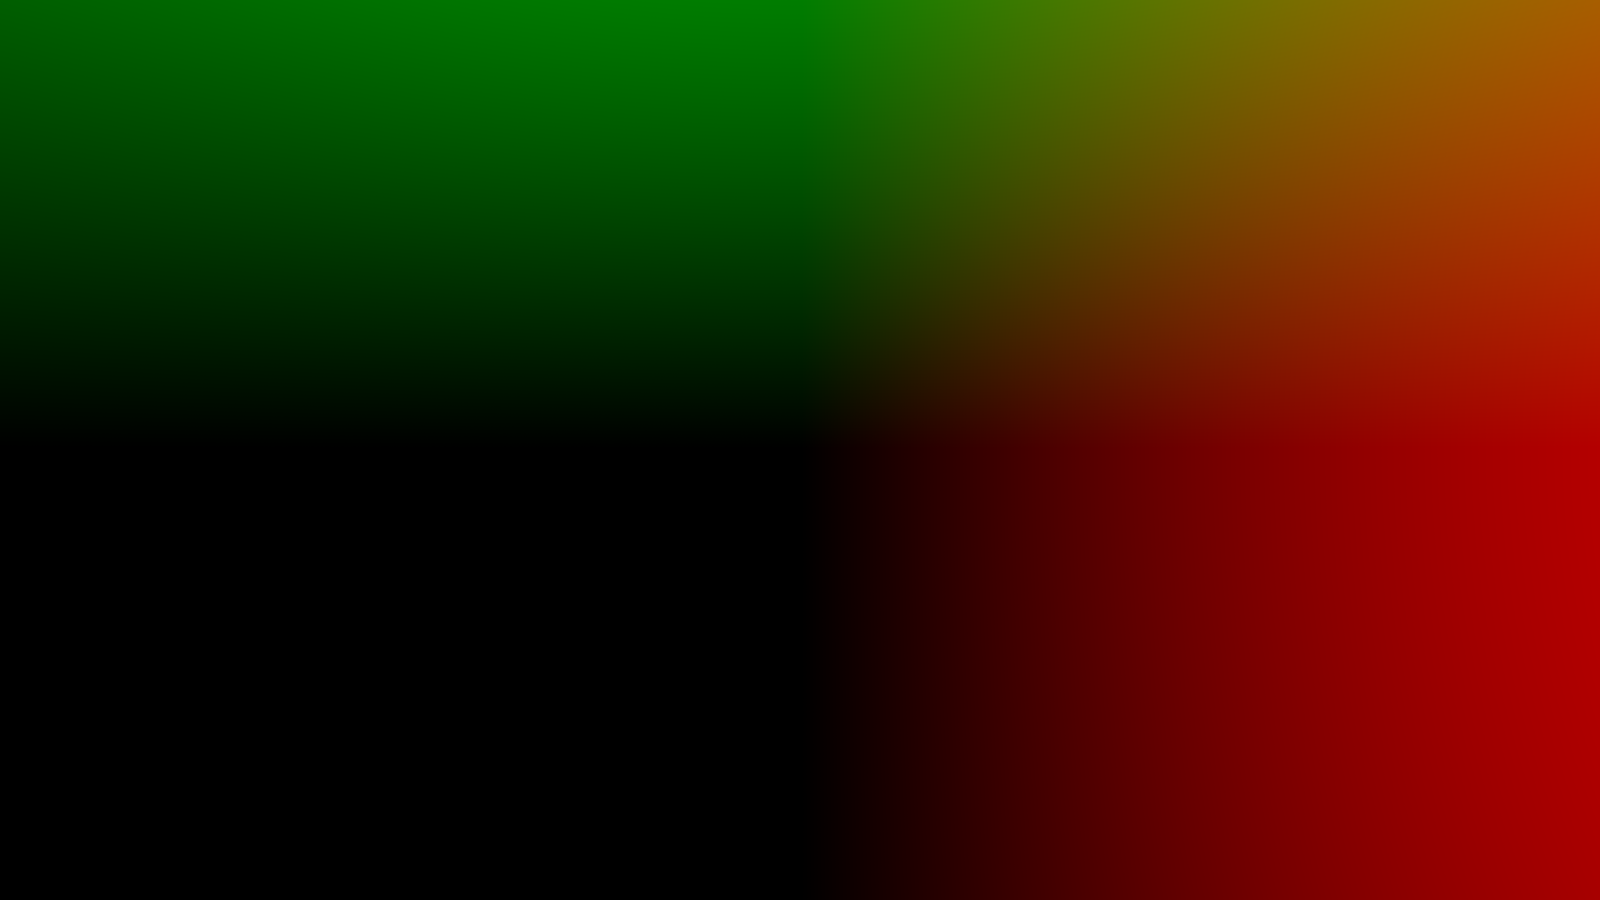

In [62]:
color = rays.dir.to_array()
img_RGB = []
for channel in color:
    img_RGB += [Image.fromarray((255 * np.clip(channel, 0, 1).reshape((camera.screen_height, camera.screen_width))).astype(np.uint8), "L")]

img = Image.merge("RGB", img_RGB)
display(img)

Das obige Bild zeigt die Richtungen der Rays als Farbe. Die Farben werden wie folgt auf die Richtung gemapped:
- Rot = x
- Grün = y
- Blau = z

Im Bild ist kein Blau zu sehen da alle die Rays in die negative z-Richtung zeigen und negative Farbwerte nicht angezeigt werden können. Die negativen z-Werte werden von `np.clip(channel, 0, 1)` auf 0 gezogen.

## Sphäre

Eine Sphäre (oft auch Kugel genannt) beschreibt eine runde Figur oder ihre Oberfläche. Wichtig dabei ist, dass jeder Punkt auf der Oberfläche die gleiche Distanz zum Mittelpunkt besitzt.

<img src="assets/Sphere.jpg" width="500" />

Wird ein Lichtstrahl ausgesendet, muss berechnet werden ob und wie der Lichstrahl zur Späre steht. Hier interessiert vorallem der erste Auftreffpunkt. Es gibt dabei 3 Möglichkeiten wie der Lichtstrahl zur Späre steht.
- Er verfehlt sie.
- Er streift sie.
- Er durchquert sie.

<img src="assets/IntersectionSphere.jpg" width="700" />

Wird die Späre verfehlt, dann gibt es **keinen** Schnittpunkt.

Wird die Späre nur gestriffen, dann gibt es **genau einen** Schnittpunkt, unser erster Auftreffpunkt (rot umkreist)

Wird die Späre durchkreuzt, dann gibt es 2 Schnittpunkte, einen Eintrittspunkt und einen Austrittspunkt. In diesem Fall interessiert uns nur der erste Auftreffpunkt, also der Eintrittspunkt (rot umkreist).

Die Schnittpunkte haben exakt den Radius r als Distanz zum Mittelpunkt.

Bevor wir die Schnittpunkte berechnen schauen wir uns noch die unterschiedlichen Positionen des Ray Ursprungs an. Der Ursprung des Rays kann 3 Positionen haben:

<img src="assets/OriginRay.jpg" width="700" />

Möchte man nun die Schnittpunkte berechnen, benötigt man die Formel für den Ray:

$$P(t)=\vec{O}+\vec{R}*t$$

Aus dieser Formel können wir nun die Formeln für die Schnittpunkte aufstellen.

$$P_1(t)=\vec{O}+\vec{R}*t_1$$

$$P_2(t)=\vec{O}+\vec{R}*t_2$$

Wir suchen nun die Werte $t_1$ und $t_2$. In der Abbildung oben sieht man, dass $t_1$ den Abstand des Ursprungs des Rays $O$ zum Punkt $P_1$ beschreibt und $t_2$ ist der Abstand des Ursprungs $O$ zum Punkt $P_2$.

Dafür brauchen wir die Gleichung der Sphäre.

Liegt der Radius im Ursprung $U (0,0,0)$ und der Punkt auf der Oberfläche so ergibt sich die Gleichung:
$$x^2 + y^2 + z^2 = r^2$$

Liegt der Radius nicht im Ursprung sondern im Punkt $M (M_x, M_y, M_z)$ ergibt sich:
$$(x-M_x)^2 + (y-M_y)^2 + (y-M_z)^2 = r^2$$

$x, y, z$ gehören in diesem Beispiel zu einem Punkt P, wodurch wir die Formel vereinfachen können:
$$(P-M) * (P-M) = (x-M_x)^2 + (y-M_y)^2 + (y-M_z)^2 = r^2$$

Wir suchen jetzt aber nicht irgendein Punkt P, sondern einen Punkt P der auf unserem Lichtstrahl $P(t)=\vec{O}+\vec{R}*t$ liegt. Daher setzen wir nun für P unsere Lichtstrahl-Gleichung ein:
$$(\vec{O}+\vec{R}*t-M) * (\vec{O}+\vec{R}*t-M) = r^2$$

Formen wir die quadratische Gleichung um erhalten wir vereinfacht:
$$t^2 * \vec{R} + t * 2*\vec{R}*(\vec{O}-M) + (\vec{O}-M) * (\vec{O}-M) - r^2 = 0$$

Wie man sieht können wir jetzt einfach die Mitternachtsformel mit

$ a = \vec{R}$,

$ b = 2*\vec{R}*(\vec{O}-M)$ und

$c = (\vec{O}-M) * (\vec{O}-M) - r^2$

anwenden, um unsere Werte $t_1$ und $t_2$ auszurechnen.


Anhand des Ergebnis der Mitternachtsformel kann auch bestimmt werden, wie viele Schnittpunkte es gibt:
- positiver Wert unter der Wurzel: **zwei** Schnittpunkte
- 0 unter der Wurzel: **ein** Schnittpunkt
- negativer Wert unter der Wurzel: **kein** Schnittpunkt


Nachfolgend sind 2 Klassen, um eine Späre/Kugel darzustellen.

Die erste Klasse ist die **primitive** Darstellung, bedeutet damit werden die Parameter der Kugel festgelegt, wie Mittelpunkt, Radius, Material, ...

Die zweite Klasse implementiert die Aktionen die beim Aussenden eines Rays abgehandelt werden müssen, bedeutet das Ausrechen des Schnittpunkts.

In [63]:
class Sphere(Primitive):
    def __init__(self, center, material, radius, max_ray_depth=5, shadow=True):
        super().__init__(center, material, max_ray_depth, shadow)
        self.collider_list += [SphereCollider(assigned_primitive=self, center=center, radius=radius)]
        self.bounded_sphere_radius = radius

    def get_uv(self, hit):
        return hit.collider.get_uv(hit)

In [64]:
class SphereCollider(Collider):
    def __init__(self,  radius, **kwargs):
        super().__init__(**kwargs)
        self.radius = radius

    def intersect(self, origin, direction):
        b = 2 * direction.dot(origin - self.center)
        c = self.center.square_length() + origin.square_length() - 2 * self.center.dot(origin) - (self.radius * self.radius)
        disc = (b ** 2) - (4 * c)
        sq = np.sqrt(np.maximum(0, disc))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        pred = (disc > 0) & (h > 0)
        M = (origin + direction * h)
        NdotD = ((M - self.center) * (1. / self.radius)).dot(direction)

        pred1 = (disc > 0) & (h > 0) & (NdotD > 0)
        pred2 = (disc > 0) & (h > 0) & (NdotD < 0)
        pred3 = True

        # return an array with hit distance and the hit orientation
        return np.select([pred1, pred2, pred3],
                         [[h, np.tile(UPDOWN, h.shape)], [h, np.tile(UPWARDS, h.shape)], FARAWAY])

    def get_normal(self, hit):
        return (hit.point - self.center) / self.radius

## Schnittpunkt von Ebene und Ray

Damit ein Punkt auf einer Ebene liegt muss folgende Gleichung erfüllt sein:

$$(\vec{p} - \vec{p_0}) * \vec{n} = 0$$

- $\vec{p}$  Punkt auf Ebene
- $\vec{p_0}$ Mittelpunkt der Ebene
- $\vec{n}$ Normalenvektor der Ebene

Der Ray ist wie folgt definiert:
$$P = \vec{O}+\vec{R}*t$$

- $\vec{O}$ Stützvektor
- $\vec{R}$ Richtungsvektor

Daraus folgt:
$$((\vec{O}+\vec{R}*t) - \vec{p_0}) * \vec{n} = 0$$

Eine Umformung nach t ergibt:
$$t = \frac{(\vec{p_0} - \vec{O}) * \vec{n}}{\vec{R} * \vec{n}}$$

<img src="assets/PlaneIntersection.jpg" width=300></img>

Setzt man t wieder in die Formel des Rays ein erhält man den Schnittpunkt von Ray und Ebene. Der Verbindungsvektor des Schnittpunks mit dem Mittelpunkt der Ebene liegt in der Ebene.
Projiziert man diesen Verbindungsvektor auf die Achsen der Ebene, kann bestimmt werden, ob der Endpunkt der Schnittpunkt innerhalb einer gegeben Breite und Länge der Ebene liegt.

Nachfolgend sind 2 Klassen, um eine Ebene darzustellen.

Die erste Klasse ist die **primitive** Darstellung, bedeutet damit werden die Parameter der Ebene festgelegt, wie Mittelpunkt, Breite, Höhe, Material, ...

Die zweite Klasse implementiert die Aktionen die beim Aussenden eines Rays abgehandelt werden müssen, bedeutet das Berechnen des Schnittpunkts.

In [65]:
class Plane(Primitive):
    def __init__(self, center, material, width, height, u_axis, v_axis, max_ray_depth=5, shadow=True):
        super().__init__(center, material, max_ray_depth, shadow)
        self.collider_list = [PlaneCollider(self, center, u_axis, v_axis, width/2, height/2)]
        self.width = width   
        self.height = height
        self.bounded_sphere_radius = np.sqrt((width/2)**2 + (height/2)**2)

In [66]:
class PlaneCollider(Collider):
    def __init__(self, assigned_primitive, center, u_axis, v_axis, w, h, uv_shift=(0, 0)):
        super().__init__(assigned_primitive, center)
        self.normal = u_axis.cross(v_axis).normalize()
        self.w = w
        self.h = h
        self.u_axis = u_axis
        self.v_axis = v_axis
        self.uv_shift = uv_shift

    def intersect(self, origin, direction):
        # https://samsymons.com/blog/math-notes-ray-plane-intersection/
        nominator = self.normal.dot(self.center - origin)
        denominator = self.normal.dot(direction)
        denominator = np.where(denominator == 0., 1e-6, denominator)

        distance = nominator / denominator

        point = origin + direction * distance
        vec_in_plane = point - self.center

        u = self.u_axis.dot(vec_in_plane)
        v = self.v_axis.dot(vec_in_plane)
        # projection from vec_in_plane on u_axis and v_axis

        hit_inside = (np.fabs(u) <= self.w) & (np.fabs(v) <= self.h) & (distance > 0)
        # distance has to be > 0, so we only consider hits in the positive direction
        hit_UPWARDS = (denominator < 0)   # we hit the plane against its normal vector
        hit_UPDOWN = np.logical_not(hit_UPWARDS)    # we hit the plane in the direction of its normal vector

        pred1 = hit_inside & hit_UPWARDS
        pred2 = hit_inside & hit_UPDOWN
        pred3 = True
        return np.select([pred1, pred2, pred3], [[distance, np.tile(UPWARDS, distance.shape)], [distance, np.tile(UPDOWN, distance.shape)], FARAWAY])

    def get_normal(self, hit):
        return self.normal

## Materialien

Bisher betrachten wir die Intersektion von Lichtstrählen und Objekten. Um ein Bild erzeugen zu können müssen allerdings die Materialien der Objekte miteinbezogen werden.
Es gibt verschiedene Arten von Materialien:
- Spiegelnde Materialien: Strahl wird in **einem** Winkel reflektiert
- Diffuse Materialien: Strahl wird in **vielen** Winkeln reflektiert
- Emittierende Materialien: Verstärken den Strahl in **vielen** Winkeln